In [79]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import itertools

### Hogg's Data

In [42]:
def make_data(seed=17, N=2**12, M=2**16, tiny=0.1):
    rng = np.random.default_rng(seed)
    latent_y = rng.uniform(size=N)
    X = rng.normal(size=(N, M)) + tiny * rng.normal(size=M)[None, :] ** 3 * latent_y[:, None] ** 1.5
    scales, shifts = 100. * rng.normal(size=M) ** 3, 100. * rng.normal(size=M) ** 3
    X *= scales[None, :]
    X += shifts[None, :]
    Y = latent_y + 0.02 * rng.normal(size=N)
    si = np.argsort(Y)
    return X[si], Y[si]

X, Y = make_data()
N, M = X.shape
assert(len(Y) == N)
print("feature shape", N, "by", M)

feature shape 4096 by 65536


### Choose one very good feature from the data set you used for Problem Set 1, and train a Gaussian Process to predict the labels based on that one feature. 

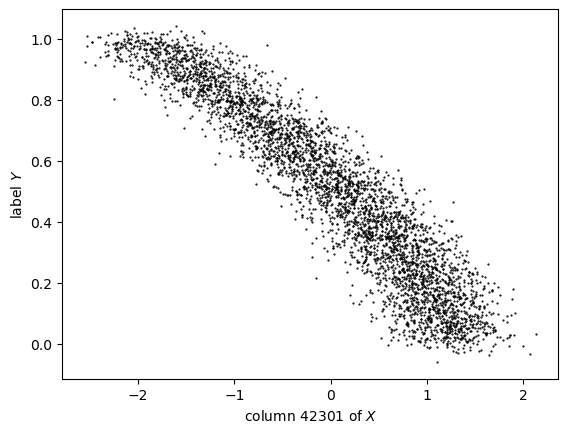

In [56]:
#here's an idea: let's just choose the feature that Hogg chose for plotting. That's a good predictor
i = 42301
plt.scatter(X[:,i], Y, s=0.3, c="k")
plt.xlabel("column {} of $X$".format(i))
plt.ylabel("label $Y$");

### Re-scale both the features X and labels Y you are using so they have zero mean and unit variance. That scaling should be done on the train, validation, and test data all treated as one data set. That is, all X data should be scaled with the same offset and scale, and all Y data should be scaled with the same offset and scale.

In [44]:
#normalization
X_data, Y_data = X[:, i], Y
mu_x, sigma_x = np.mean(X_data), np.std(X_data)
X_data -= mu_x
X_data /= sigma_x
print(np.mean(X_data), np.std(X_data))

-5.551115123125783e-17 0.9999999999999999


### Use a Matern 3/2 kernel to begin, plus a diagonal (identity or delta-function) kernel. This model should have three free parameters (Matern amplitude sigma-squared, Matern width rho, identity amplitude). Predict the labels using this Gaussian process, 27 times, setting the values of the three parameters to [3., 0.3, 0.03], [1., 0.1, 0.01], and [0.1, 0.01, 0.001]. 

### Recall: $\hat{Y}^* = K_*(K+\alpha I)^{-1}Y$

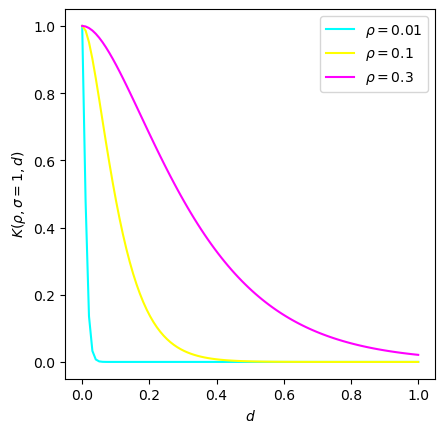

In [45]:
#visualize the matern 3/2 kernel for different rho. It's like a correlation function, which would make rho the correlation length. 
mk = lambda d, sigma, rho: sigma**2 * (1+(np.sqrt(3))*d/rho) * np.exp(-np.sqrt(3*d*d)/rho)

fig, ax = plt.subplots()
rho_list = [.01, .1, .3]
col_list = ['cyan', 'yellow', 'magenta']
dlist = np.linspace(0, 1, 100)
sigma = 1

for j in range(len(rho_list)):
    rho = rho_list[j]
    k = [mk(d, sigma, rho) for d in dlist]
    ax.plot(dlist, k, color = col_list[j], label = r'$\rho = {}$'.format(rho))

ax.set_xlabel(r'$d$')
ax.set_ylabel(r'$K (\rho, \sigma = 1, d)$')
ax.legend()
ax.set_aspect('equal');

In [46]:
#now, let's split into training, validation
X_train, X_temp, Y_train, Y_temp = train_test_split(X_data, Y, test_size=0.5, random_state=420) #this splits the data so that 60% is training. 
#The rest is temp
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=420) #from the temp, half is test, half is validation

In [47]:
def gp(x, y, x_star, y_star, sigma, rho, alpha):
    '''x_star is the test data. y_star are the labels corresponding to the test data.
    alpha will be the identity coefficient, rho is the distance that's like correlation length, sigma is the amplitude of Matern kernel'''
    
    #construct identity matrix and distances. Kernel from distances
    dim = x.shape[0]
    I = alpha * np.identity(dim)
    d = np.subtract.outer(x, x)
    d_star = np.subtract.outer(x_star, x)
    d_star_star = np.subtract.outer(x_star, x_star)
    K = mk(d, sigma, rho)
    K_star = mk(d_star, sigma, rho)
    K_star_star = mk(d_star_star, sigma, rho)

    #prediction
    yhat_star = K_star @ np.linalg.solve(K + I, np.identity(dim)) @ y

    #rmse
    n = len(y_star)
    rmse = np.sqrt(np.sum((yhat_star - y_star)**2/n))

    #compute log-likelihood
    V = K_star_star - (K_star @ np.linalg.solve(K, np.identity(dim)) @ K_star.T) #V = K** - K* K^-1 K*.T is the covariance matrix
    _, ld = np.linalg.slogdet(V)
    ll = (-.5 * (yhat_star - y_star) @ np.linalg.solve(V, np.identity(V.shape[0])) @ (yhat_star - y_star).T) - .5*ld

    return yhat_star, V, rmse, ll

def gp_plot(x, y, x_star, y_star, sigma, rho, alpha):
    
    indices = np.argsort(x_star)
    x_star = x_star[indices]
    y_star = y_star[indices]
    yhat_star, V, rmse, ll = gp(x, y, x_star, y_star, sigma, rho, alpha)

    fig, ax = plt.subplots(figsize = (6,4))
    ax.scatter(x_star, y_star, marker = 'o', s = 32, facecolor = 'violet', edgecolor = 'k', alpha = .4)
    txt = r'$\sigma = {}$'.format(sigma) + '\n' + r'$\rho = {}$'.format(rho) + '\n' + r'$\alpha = {}$'.format(alpha)
    ax.plot(x_star, yhat_star, 'k-', label = txt, alpha = .8)

    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y_{\mathrm{train}}$')
    ax.legend()

    plt.show()

In [23]:
sigma_list = [3, 1., .1]
rho_list = [.3, .1, .01]
alpha_list = [.03, .01, .001]

cart_prod = list(itertools.product(sigma_list, rho_list, alpha_list)) #cartesian product
for params in cart_prod:
    sigma, rho, alpha = params

    #evaluate on test data
    _, _, rmse, ll = gp(X_train, Y_train, X_test, Y_test, sigma, rho, alpha)
    print(f'[sigma, rho, alpha] = {params}\t', f'RMSE = {rmse}\t', f'log-likelihood = {ll}')

[sigma, rho, alpha] = (3, 0.3, 0.03)	 RMSE = 0.11332296816681188	 log-likelihood = 987.0685277355389
[sigma, rho, alpha] = (3, 0.3, 0.01)	 RMSE = 0.11767702201338215	 log-likelihood = 967.926135218433
[sigma, rho, alpha] = (3, 0.3, 0.001)	 RMSE = 0.12238383926956393	 log-likelihood = 945.5258852067088
[sigma, rho, alpha] = (3, 0.1, 0.03)	 RMSE = 0.11998705965071063	 log-likelihood = 510.22184978519283
[sigma, rho, alpha] = (3, 0.1, 0.01)	 RMSE = 0.12289010048481523	 log-likelihood = 506.64929377986573
[sigma, rho, alpha] = (3, 0.1, 0.001)	 RMSE = 0.1253321095181444	 log-likelihood = 503.6631641424435
[sigma, rho, alpha] = (3, 0.01, 0.03)	 RMSE = 0.16150460703425498	 log-likelihood = -588.4492692943578
[sigma, rho, alpha] = (3, 0.01, 0.01)	 RMSE = 0.1620002179224951	 log-likelihood = -588.4874539981511
[sigma, rho, alpha] = (3, 0.01, 0.001)	 RMSE = 0.16232772933087056	 log-likelihood = -588.515872660907
[sigma, rho, alpha] = (1.0, 0.3, 0.03)	 RMSE = 0.10354595860780921	 log-likelihood =

#### What setting of the hyperparameters gave the most accurate MSE to the validation data?
#### >>> $\sigma = 0.1, \rho = 0.3, \alpha = 0.001$

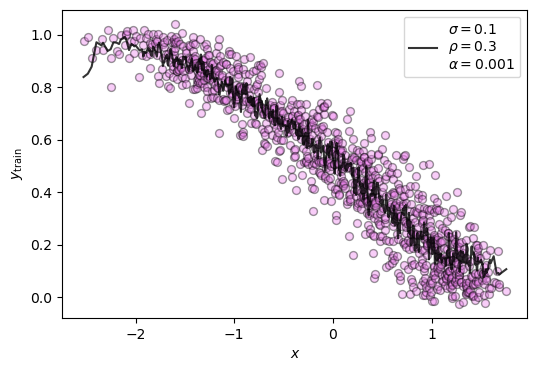

In [21]:
yhat_star = gp_plot(X_train, Y_train, X_test, Y_test, .1, .3, .001)

#### What setting of the hyperparameters gave the most accurate LL to the validation data?
#### >>> $\sigma = 3, \rho = 0.3, \alpha = 0.03$ 

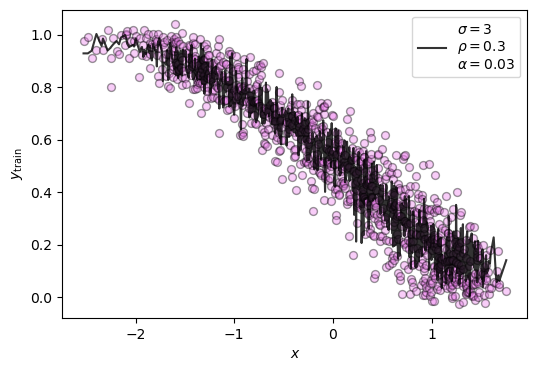

In [22]:
yhat_star = gp_plot(X_train, Y_train, X_test, Y_test, 3, 0.3, 0.03)

### Make 27 x 2 plots of the mean and variance of the prediction as a continuous line (finely sampled line). Make 2 plots for every one of the 27 parameters: One zoomed out, showing a range wider than the full label range, and one zoomed in, showing a small fraction of the label range, showing the details of the predictions at small scales. Share your favorite plots on discord.

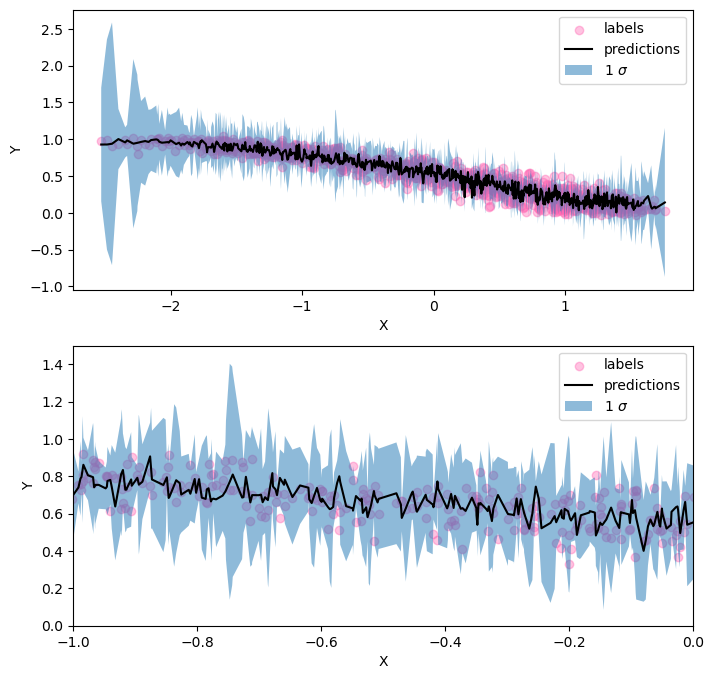

In [52]:
#...being super lazy...for now, let's just do one. 
yhat_star, V, rmse, ll = gp(X_train, Y_train, X_test, Y_test, 3, 0.3, 0.03)

fig, axs = plt.subplots(2, 1, figsize = (8,8))
for ax in axs:
    ax.scatter(X_test, Y_test, marker = 'o', color = 'hotpink', alpha = .4, label = 'labels')
    
    vars = np.diag(V)
    stdevs = np.sqrt(vars)
    indices = np.argsort(X_test)
    X_test = X_test[indices]
    Y_test = Y_test[indices]
    yhat_star = yhat_star[indices]
    
    ax.plot(X_test, yhat_star, 'k-', label = 'predictions')
    ax.fill_between(X_test, yhat_star-stdevs, yhat_star+stdevs, alpha = .5, label = r'1 $\sigma$')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend();
axs[1].set_xlim([-1,0])
axs[1].set_ylim([0, 1.5]);

### If we think of GP as an interpolation scheme, then clearly, it works better in the middle as opposed to near the endpoints. Also we can see that in regions where the we have fewer points, GP does a worse job.

### Now train and evaluate a GP (re-do parts a and b) using not one feature but 8 features. What additional decisions do you have to make and how did you make them

In [80]:
#choose 8 best features from sklearn
X_new = SelectKBest(score_func=f_regression, k=8).fit_transform(X, Y)
print(X_new.shape)

C:\Users\ajati\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:331: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)


(4096, 8)


In [81]:
#now, let's split into training, validation
X_train, X_temp, Y_train, Y_temp = train_test_split(X_new, Y, test_size=0.5, random_state=420) #this splits the data so that 60% is training. 
#The rest is temp
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=420) #from the temp, half is test, half is validation

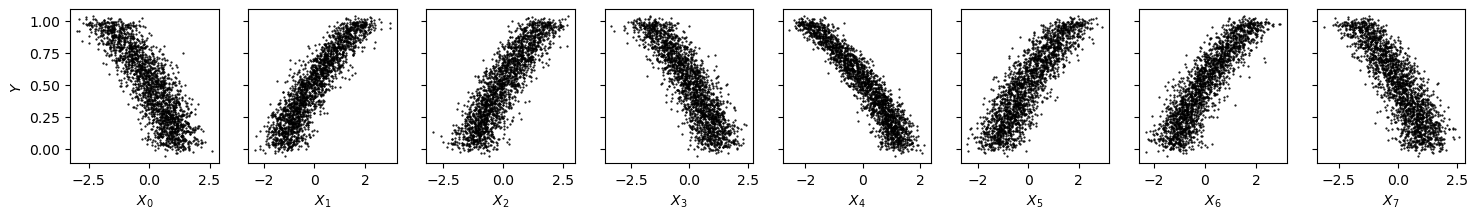

In [92]:
fig, axs = plt.subplots(1,8, figsize =(18,2), sharey=True)
axs[0].set_ylabel(r'$Y$');

for i in range(8):
    X_data = X_train[:,i]
    Y_data = Y_train
    
    #normalize:
    mu_x, sigma_x = np.mean(X_data), np.std(X_data)
    X_data -= mu_x
    X_data /= sigma_x
    
    ax = axs[i]
    ax.scatter(X_data, Y_data, s = .3, c='k')
    ax.set_xlabel(f'$X_{i}$')

### Putatively, sklearn's feature selection using (f-test for regression) appears to be doing a stellar job!

In [106]:
def mvgp(X, y, X_star, y_star, sigma, rho, alpha):
    '''Multivariate version of the gaussian process function above'''

    dim = X.shape[0]
    I = alpha * np.identity(dim)

    #construct distances, K, etc. Have to be careful when constructing distances matrix. We'll compute euclidean distance between features
    d = np.linalg.norm(X[:, np.newaxis, :] - X[np.newaxis, :, :], axis=-1)
    d_star = np.linalg.norm(X_star[:, np.newaxis, :] - X[np.newaxis, :, :], axis=-1)
    d_star_star = np.linalg.norm(X_star[:, np.newaxis, :] - X_star[np.newaxis, :, :], axis=-1)
    K = mk(d, sigma, rho)
    K_star = mk(d_star, sigma, rho)
    K_star_star = mk(d_star_star, sigma, rho)

    #preds, rmse, and covariance
    yhat_star = K_star @ np.linalg.solve(K + I, y)
    n = len(y_star)
    rmse = np.sqrt(np.sum((yhat_star - y_star)**2) / n)
    V = K_star_star - (K_star @ np.linalg.solve(K, K_star.T))
    _, ld = np.linalg.slogdet(V)
    ll = (-0.5 * (yhat_star - y_star) @ np.linalg.solve(V, (yhat_star - y_star).T) - 0.5 * ld)

    return yhat_star, V, rmse, ll

#### I ran it for multiple {$\rho$, $\alpha$, $\sigma$} values but results appeared to be sensitive only to $\sigma$...not sure what's up with that

In [111]:
sigma_list = [3, 1., .1]
for sigma in sigma_list:
    rho, alpha = .3, .03

    #evaluate on test data
    _, _, rmse, ll = mvgp(X_train, Y_train, X_test, Y_test, sigma, rho, alpha)
    print(f'[sigma, rho, alpha] = {params}\t', f'log-likelihood = {ll}')

[sigma, rho, alpha] = (0.1, 0.01, 0.001)	 log-likelihood = -1144.074653525092
[sigma, rho, alpha] = (0.1, 0.01, 0.001)	 log-likelihood = -171.86102936026225
[sigma, rho, alpha] = (0.1, 0.01, 0.001)	 log-likelihood = -14828.255800800289
